In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.label.value_counts()

cake             1184
pasta            1072
steak            1048
fried_chicken    1034
pizza             963
grilled_eel       951
ramen             881
pork_cutlet       869
janchi_guksu      856
tteokbokki        841
jajangmyeon       833
pork_belly        789
Name: label, dtype: int64

In [4]:
cd train 

c:\Users\AI06\Desktop\DL\train


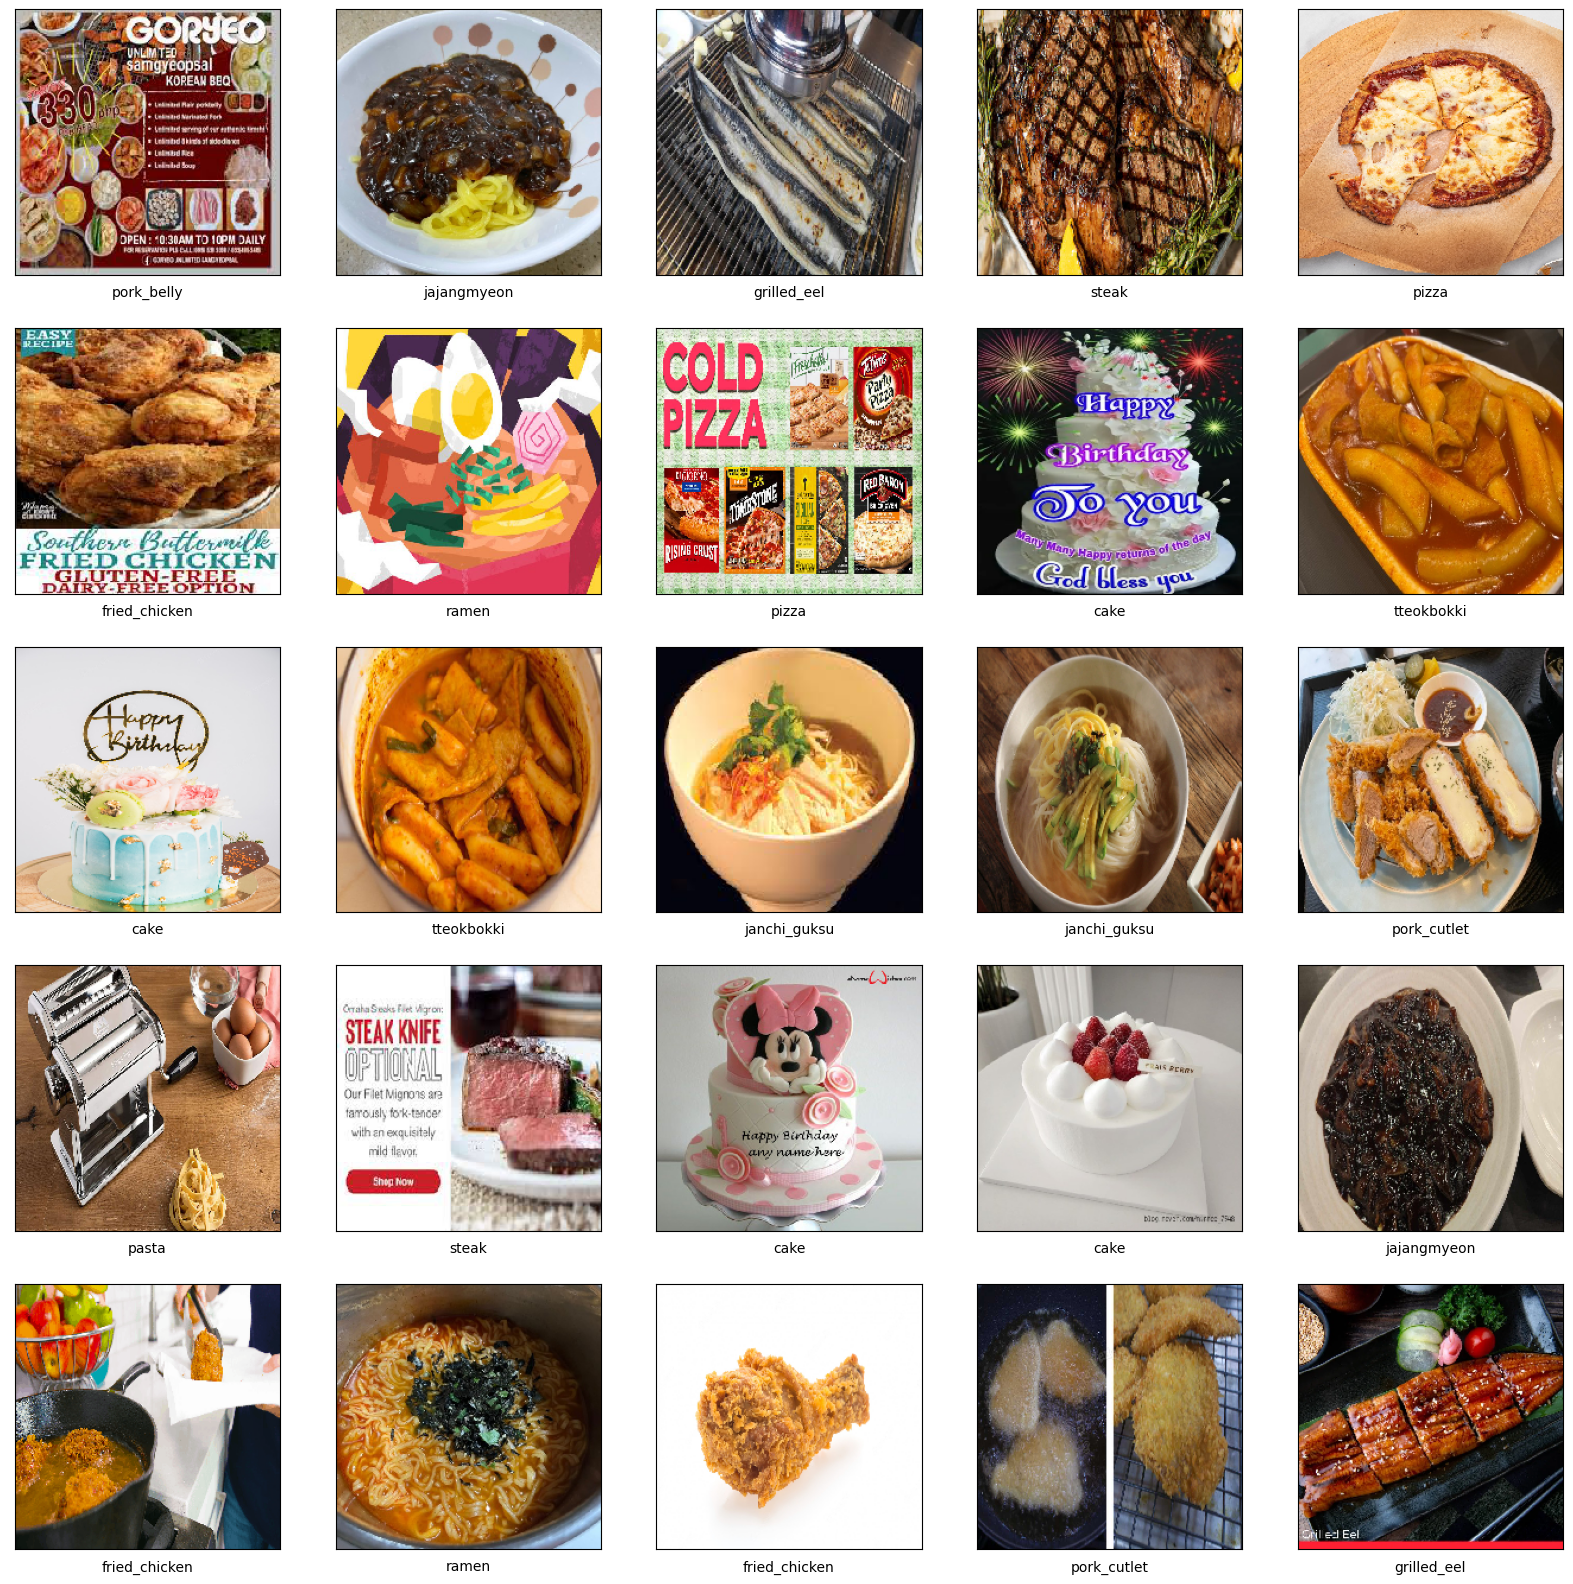

In [5]:
# 이미지 시각화

plt.figure(figsize=(20, 20))
index = np.random.randint(len(train_df), size=25)
for i in range(25):
    label = train_df['label'][index[i]]
    path_img = train_df['image'][index[i]]
    path_img = os.path.join(os.path.join(label, path_img))

    img = image.load_img(path_img, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(
    train_df, test_size=0.1, stratify=train_df['label'])  # 라벨 비율 대로 데이터 분리 
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)


In [7]:
cd .. 

c:\Users\AI06\Desktop\DL


In [8]:
def cls(x): return os.path.join('train', '_'.join(x.split('_')[1:-1])+ '\\' +x)

train['image'] = train['image'].map(lambda x: cls(x))
train.head(10)

valid['image'] = valid['image'].map(lambda x: cls(x))
valid.head(10)


image          label
0                    train\cake\google_cake_39.jpg           cake
1   train\fried_chicken\naver_fried_chicken_32.jpg  fried_chicken
2                 train\pizza\google_pizza_232.jpg          pizza
3  train\fried_chicken\naver_fried_chicken_412.jpg  fried_chicken
4                 train\pasta\google_pasta_531.jpg          pasta
5                 train\steak\google_steak_352.jpg          steak
6     train\jajangmyeon\google_jajangmyeon_131.jpg    jajangmyeon
7        train\pork_belly\naver_pork_belly_367.jpg     pork_belly
8                   train\pasta\naver_pasta_90.jpg          pasta
9     train\grilled_eel\google_grilled_eel_521.jpg    grilled_eel

In [10]:
# 데이터 증강 => 배치사이즈 

height, width, channel = (224, 224, 3)
batch_size = 32
labels = train.label.unique().tolist()

# 증강 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=[0.8, 1],
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory='train',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(height, width))


# 증강 작업 없는 걸 valid로 설정 
valid_datagen = ImageDataGenerator(rescale=1. / 255.)
valid_generator = valid_datagen.flow_from_directory(directory='train',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(height, width))


Found 11321 images belonging to 12 classes.
Found 11321 images belonging to 12 classes.


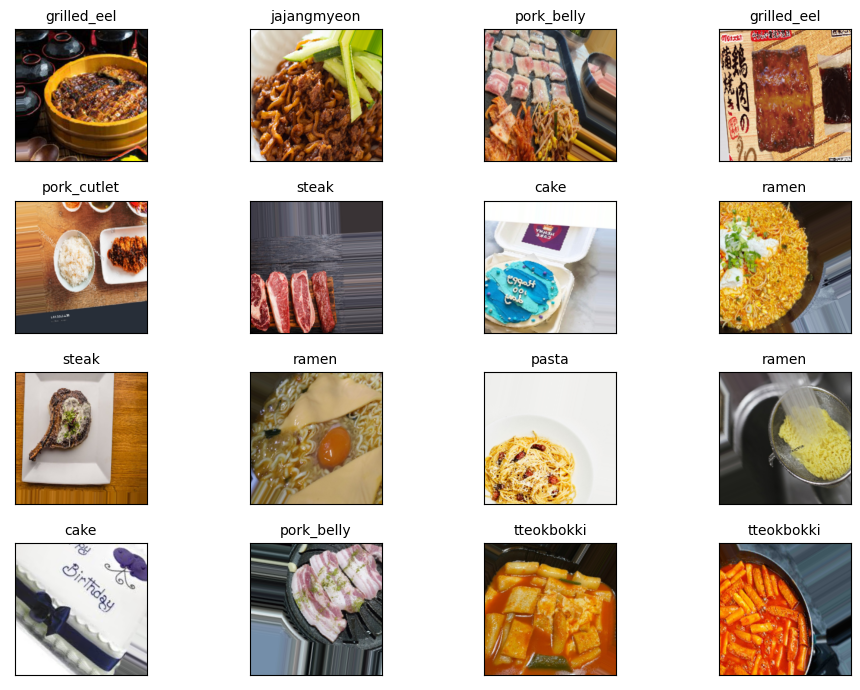

In [22]:
# 데이터 증강 시각화

pred2label = {}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x


plt.figure(figsize=(10, 7))
index = np.random.randint(len(train_df), size=batch_size)
x_augs, y_augs = train_generator.next()
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_augs[i, :, :, :])
    plt.title(pred2label[np.argmax(y_augs[i, :])], fontsize=10)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.tight_layout()
plt.show()


### 모델링 

In [29]:
from tensorflow.keras.applications import DenseNet121, ResNet152V2, Xception, EfficientNetB7
from tensorflow.keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint


In [30]:
input_tensor = Input(shape=(224, 224, 3))
base_model = Xception(input_tensor=input_tensor,include_top=False, weights='imagenet')


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(12, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)


83683744/83683744 [==============================] - 24s 0us/step


In [32]:
# 가중치 동결 후 모델 확인 =>  Trainable params: 3,126,380 << Non-trainable params: 20, 861, 480
base_model.trainable = False
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [33]:
# 모델 컴파일
model.compile(optimizer=Adam(0.0003), loss="categorical_crossentropy", metrics=["accuracy"])

In [34]:
# 모델 훈련
history = model.fit(train_generator, validation_data=valid_generator, epochs=20)


Epoch 1/20
 32/354 [=>............................] - ETA: 2:07 - loss: 2.4034 - accuracy: 0.1318

c:\Users\AI06\anaconda3\envs\ml\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


354/354 [==============================] - 236s 663ms/step - loss: 1.3884 - accuracy: 0.5393 - val_loss: 0.8056 - val_accuracy: 0.7432
Epoch 2/20
354/354 [==============================] - 236s 666ms/step - loss: 0.8700 - accuracy: 0.7318 - val_loss: 0.6096 - val_accuracy: 0.8084
Epoch 3/20
354/354 [==============================] - 237s 671ms/step - loss: 0.7717 - accuracy: 0.7675 - val_loss: 0.5716 - val_accuracy: 0.8183
Epoch 4/20
354/354 [==============================] - 235s 664ms/step - loss: 0.7077 - accuracy: 0.7822 - val_loss: 0.5087 - val_accuracy: 0.8473
Epoch 5/20
354/354 [==============================] - 236s 666ms/step - loss: 0.6740 - accuracy: 0.7936 - val_loss: 0.5277 - val_accuracy: 0.8330
Epoch 6/20
354/354 [==============================] - 236s 667ms/step - loss: 0.6295 - accuracy: 0.8067 - val_loss: 0.4554 - val_accuracy: 0.8585
Epoch 7/20
354/354 [==============================] - 235s 665ms/step - loss: 0.6027 - accuracy: 0.8172 - val_loss: 0.4612 - val_accura

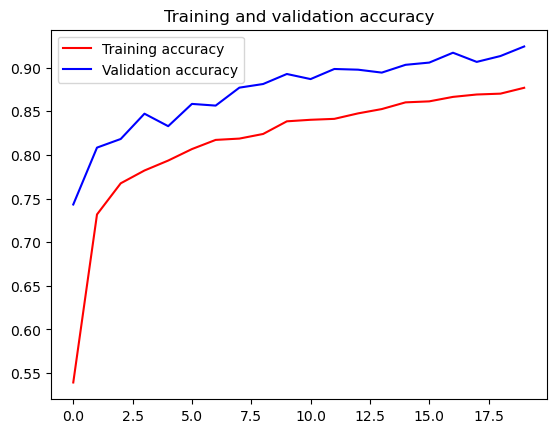

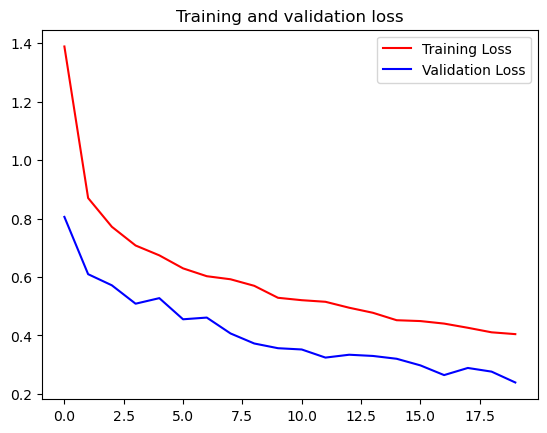

In [35]:
# 학습 곡선 확인 

def plot_history():
    plt.plot(range(20), history.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(range(20), history.history['val_accuracy'],'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(range(20), history.history['loss'], 'r', label='Training Loss')
    plt.plot(range(20), history.history['val_loss'], 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    

plot_history()


In [36]:
# 조기멈춤
stop = EarlyStopping(patience=5)

# 자동 저장
checkpoint = ModelCheckpoint("best_model/model_weights", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1, save_best_only=True)
callbacks = [stop, checkpoint]


In [37]:
# 가중치 동결 해제  => Trainable params: 23,933,332 > Non-trainable params: 54, 528
base_model.trainable = True
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [38]:
# 모델 컴파일(학습률을 더 낮게 조정)
model.compile(optimizer=Adam(0.00003),
              loss="categorical_crossentropy", metrics=["accuracy"])

In [39]:
# 모델 훈련
history = model.fit(train_generator, callbacks=callbacks, validation_data=valid_generator, batch_size=16, epochs=10)

Epoch 1/10
354/354 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.8217
Epoch 1: val_accuracy improved from -inf to 0.92412, saving model to best_model\model_weights
354/354 [==============================] - 240s 666ms/step - loss: 0.5815 - accuracy: 0.8217 - val_loss: 0.2449 - val_accuracy: 0.9241
Epoch 2/10
354/354 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8892
Epoch 2: val_accuracy improved from 0.92412 to 0.94603, saving model to best_model\model_weights
354/354 [==============================] - 239s 674ms/step - loss: 0.3578 - accuracy: 0.8892 - val_loss: 0.1749 - val_accuracy: 0.9460
Epoch 3/10
354/354 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.9116
Epoch 3: val_accuracy improved from 0.94603 to 0.96166, saving model to best_model\model_weights
354/354 [==============================] - 239s 674ms/step - loss: 0.2835 - accuracy: 0.9116 - val_loss: 0.1225 - val_accuracy: 0.9617
Epoch 4/10
354/354 

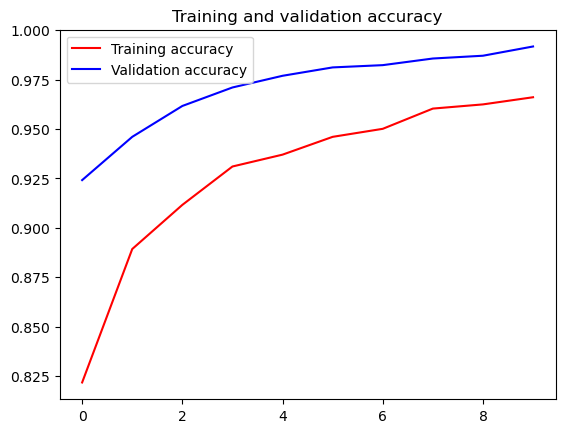

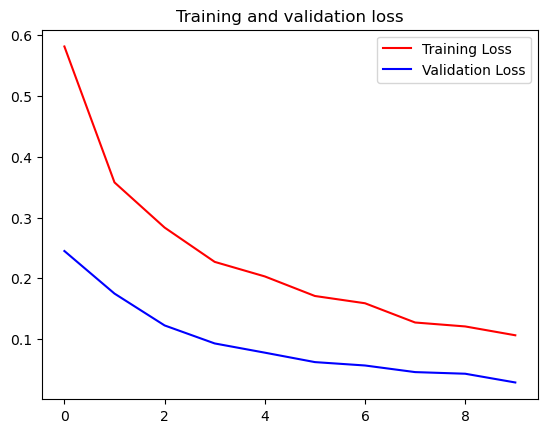

In [41]:
# 학습 곡선 확인

def plot_history():
    plt.plot(range(10), history.history['accuracy'],
             'r', label='Training accuracy')
    plt.plot(
        range(10), history.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(range(10), history.history['loss'], 'r', label='Training Loss')
    plt.plot(
        range(10), history.history['val_loss'], 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_history()


### Test 

In [42]:
test_df = pd.read_csv("submission.csv")
test_df.head(5)

image  label
0  test_1553.jpg    NaN
1  test_2202.jpg    NaN
2  test_1556.jpg    NaN
3   test_660.jpg    NaN
4   test_677.jpg    NaN

In [43]:
batch_size = len(test_df["image"])
height, width, channel = 224, 224, 3

path = os.path.join('test')

test_image = np.zeros((batch_size, height, width, channel))
print(test_image.shape)

cnt = 0

(2766, 224, 224, 3)


In [44]:
for i in range(len(test_df["image"])):
    path_img = test_df['image'][i]
    img = image.load_img(os.path.join(path, path_img),
                         target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor, dtype="float32")

    img_tensor /= 255

    img_tensor = np.expand_dims(img_tensor, axis=0)

    test_image[i] = img_tensor

    if (i % 100== 0):
        print(str(i) + " 완료")  # 진행 상황 확인용


0 완료
10 완료
20 완료
30 완료
40 완료
50 완료
60 완료
70 완료
80 완료
90 완료
100 완료
110 완료
120 완료
130 완료
140 완료


c:\Users\AI06\anaconda3\envs\ml\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


150 완료
160 완료
170 완료
180 완료
190 완료
200 완료
210 완료
220 완료
230 완료
240 완료
250 완료
260 완료
270 완료
280 완료
290 완료
300 완료
310 완료
320 완료
330 완료
340 완료
350 완료
360 완료
370 완료
380 완료
390 완료
400 완료
410 완료
420 완료
430 완료
440 완료
450 완료
460 완료
470 완료
480 완료
490 완료
500 완료
510 완료
520 완료
530 완료
540 완료
550 완료
560 완료
570 완료
580 완료
590 완료
600 완료
610 완료
620 완료
630 완료
640 완료
650 완료
660 완료
670 완료
680 완료
690 완료
700 완료
710 완료
720 완료
730 완료
740 완료
750 완료
760 완료
770 완료
780 완료
790 완료
800 완료
810 완료
820 완료
830 완료
840 완료
850 완료
860 완료
870 완료
880 완료
890 완료
900 완료
910 완료
920 완료
930 완료
940 완료
950 완료
960 완료
970 완료
980 완료
990 완료
1000 완료
1010 완료
1020 완료
1030 완료
1040 완료
1050 완료
1060 완료
1070 완료
1080 완료
1090 완료
1100 완료
1110 완료
1120 완료
1130 완료
1140 완료
1150 완료
1160 완료
1170 완료
1180 완료
1190 완료
1200 완료
1210 완료
1220 완료
1230 완료
1240 완료
1250 완료
1260 완료
1270 완료
1280 완료
1290 완료
1300 완료
1310 완료
1320 완료
1330 완료
1340 완료
1350 완료
1360 완료
1370 완료
1380 완료
1390 완료
1400 완료
1410 완료
1420 완료
1430 완료
1440 완료
1450 완료
1460 완료
1470 완료
1480 완료
1490 완료
1500 

In [ ]:
# 학습된 모델로 예측

model.load_weights('./best_model/model_weights')

In [45]:
predictions = model.predict(test_image)

87/87 [==============================] - 7s 72ms/step


In [46]:
test_df['label'] = [pred2label[np.argmax(pred)] for pred in predictions]

print(test_df)

test_df.to_csv('Xception_unfreeze.csv', index=False)

              image          label
0     test_1553.jpg     pork_belly
1     test_2202.jpg          ramen
2     test_1556.jpg    pork_cutlet
3      test_660.jpg          pizza
4      test_677.jpg          ramen
...             ...            ...
2761  test_2189.jpg          pasta
2762   test_223.jpg  fried_chicken
2763   test_303.jpg   janchi_guksu
2764  test_1681.jpg   janchi_guksu
2765   test_777.jpg           cake

[2766 rows x 2 columns]
